# Documentation

**Data Source:** https://www.openml.org/search?type=data&sort=runs&id=1597&status=active

**Data Context:** The dataset relates to credit card transactions made my European card holders over a two day period in September 2013. It is highly imbalanced with 284,315 genuine transactions comapred to 492 fraudulent.

A PCA transformation has been applied to all features, except Time (duration since the first transaction), Amount (transaction value), and Class (genuine and fraudulent). The transformation is a privacy protecting function, and as such, the original features are not available.

Further information is available by following the link provided.

**Preparation Approach:** Preservation of minority class instances is a primary objective due to their scarcity and importance to the broader study. Furthermore, owing to the applied PCA transformation, domain knowledge cannot be used to explain anomalies nor aid in creating derived features. Both of these limit the pre-processing options available.

**Preparation Overview:**
* 1.0 Configuration
* 2.0 Data Inspection
* 3.0 Data Cleaning
* 4.0 Data Splitting
* 5.0 Standardisation
* 6.0 Exports

# 1.0 Configuration

### | 1.1 Imports

In [1]:
import gc

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### | 1.2 Colours

In [2]:
# graph data colours
blue_data = '#20a4f3' 
pink_data ='#ff3366'

# graph layout colours
grey_bg = '#f5f5f5'       # light grey for backgrounds
grey_grid = '#DADADA'     # mid grey for gridlines 
grey_borders = '#282828'  # dark grey for borders

### | 1.3 Functions

In [3]:
# apply a consistent style to graphs
def apply_style(ax, title, xlabel, ylabel):

    # label formatting
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel(xlabel, fontsize=16, fontweight="bold")
    ax.set_ylabel(ylabel, fontsize=16, fontweight="bold")

    # graph appearance
    ax.grid(color=grey_grid, which="both")
    ax.set_facecolor(grey_bg)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():  # graph border
        spine.set_edgecolor(grey_borders)


# create a bar chart with a consistent style
def plot_bar(data, x_labels, title, xlabel, ylabel, ax, colors, log_scale=False):

    # graph type
    ax.bar(data.index, data.values, color=colors, log=log_scale)

    # graph labels
    ax.set_xticks(data.index)
    ax.set_xticklabels(x_labels)

    # apply formatting style
    apply_style(ax, title, xlabel, ylabel)

    # minimise overlaps
    plt.tight_layout()


# create a box plot with a consistent style
def plot_boxplot(data, x_col, y_col, title, ax, colors):

    # graph type
    sns.boxplot(x=data[x_col], y=data[y_col], ax=ax, saturation=1, palette=colors)

    # apply formatting style
    apply_style(ax, title, x_col, y_col)

    # minimise overlaps
    plt.tight_layout()


# create a histogram with a consistent style
def plot_histogram(data, title, xlabel, ylabel, ax, color):

    # graph type
    ax.hist(data, bins=50, color=color)

    # apply formatting style
    apply_style(ax, title, xlabel, ylabel)
    
    # minimise overlaps
    plt.tight_layout()
    

# create a split bar chart with a consistent style
def plot_splitbar(sets, counts, title, xlabel, ylabel, colors):

    # graph type
    ax = sns.barplot(x=sets, y=counts, palette=colors, saturation=1)

    # applies formatting style
    apply_style(ax, title, xlabel, ylabel)
    
    # minimise overlaps
    plt.tight_layout()

### | 1.4 Data

In [4]:
# load the arff file into a dataframe
data_arff = arff.loadarff("data/creditcard.arff")
data_pandas = pd.DataFrame(data_arff[0])

# clear unneeded data after loading
del data_arff
_ = gc.collect()

# force display of all dataframe columns
pd.set_option("display.max_columns", None)

### | 1.5 Random Seed

In [5]:
# variable to aid reproducibility
random_seed = 40

# 2.0 Data Inspection

### | 2.1 Dataframe Information

In [6]:
data_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Observations:** 
* There are no missing instances, as the column and row counts match the documentation.

* Class was expected to be a float or integer data type.

* Limited memory environments may benefit from converting float64 to float32.

**Actions:** 
* Investigate Class column values.

* Convert float64 to float32 for performance improvements.

### | 2.2 Target Variable Distribtution

In [7]:
data_pandas['Class'].value_counts()

Class
b'0'    284315
b'1'       492
Name: count, dtype: int64

**Observations:** 
* Classes counts match those in the documentation.

* Class values are in bytes format due to how the .arff file encodes string data.

**Actions:**
* Convert the values to binary integers to match algorithm expectations.

### | 2.3 Head Inspection

In [8]:
data_pandas.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,b'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,b'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,b'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,b'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,b'0'


**Observations:** 
* Time and Amount have a different scale to V1 to V28 as they were not PCA transformed.

**Actions:**
* Investigate statistics regarding Time and Amount in light of the scale differences.

### | 2.4 Summary Statistics

In [9]:
data_pandas.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.205498e-16,-2.406306e-15,2.238853e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437516e-15,-3.740237e-16,9.564149e-16,1.039917e-15,6.407202e-16,1.656562e-16,-3.568593e-16,2.610582e-16,4.473066e-15,5.213180e-16,1.683537e-15,-3.659966e-16,-1.223710e-16,88.349619
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000


**Observations:** 

* Time is a realistic number as the max is roughly equal to the two day timeframe stated.

* Conversion to decimal numbers shows the PCA means are close to 0, as expected.

* Amounts are mostly small and some are large, but all on a different scale to the PCA features.

**Actions:**

* Standardise Amount values to aid deep learning model performance.

# 3.0 Data Cleaning

### | 3.1 Identifying Missing Values

In [10]:
data_pandas.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

**Observations:** 

* There are no missing values across the entire dataset.

### | 3.2 Data Type Conversion

In [11]:
# convert class labels to intergers
data_pandas["Class"] = data_pandas["Class"].apply(lambda x: int(x.decode("utf-8")))

# verify transformation and counts
data_pandas["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

**Observations:** 
* Byte values now represented as 0 and 1 to match many algorithms expectations.

* Counts for both classes match original counts.

In [12]:
# identify float64 columns
cols_to_convert = data_pandas.select_dtypes(include="float64").columns

# convert float64 to float32
data_pandas[cols_to_convert] = data_pandas[cols_to_convert].astype("float32")

# verify type conversion
data_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float32
 1   V1      284807 non-null  float32
 2   V2      284807 non-null  float32
 3   V3      284807 non-null  float32
 4   V4      284807 non-null  float32
 5   V5      284807 non-null  float32
 6   V6      284807 non-null  float32
 7   V7      284807 non-null  float32
 8   V8      284807 non-null  float32
 9   V9      284807 non-null  float32
 10  V10     284807 non-null  float32
 11  V11     284807 non-null  float32
 12  V12     284807 non-null  float32
 13  V13     284807 non-null  float32
 14  V14     284807 non-null  float32
 15  V15     284807 non-null  float32
 16  V16     284807 non-null  float32
 17  V17     284807 non-null  float32
 18  V18     284807 non-null  float32
 19  V19     284807 non-null  float32
 20  V20     284807 non-null  float32
 21  V21     28

**Observations:** 
* All expected columns are now float32, reducing study memory requirements.

### | 3.3 Identifying Duplicate Entries

In [13]:
# count each class in the dataset
class_count = data_pandas["Class"].value_counts()

# count duplicates and filter
duplicates = data_pandas[data_pandas.duplicated()]
zero_duplicates = duplicates[duplicates["Class"] == 0].shape[0]
one_duplicates = duplicates[duplicates["Class"] == 1].shape[0]
total_duplicates = zero_duplicates + one_duplicates

# calculate duplicate percentages
zero_percentage = (zero_duplicates / class_count[0]) * 100
one_percentage = (one_duplicates / class_count[1]) * 100
total_percentage = (zero_percentage + one_percentage) / 2

# print duplicate information
print("Exact Duplicates:")
print(f"0\t {zero_duplicates} \t ({zero_percentage:.2f}%)")
print(f"1\t {one_duplicates} \t ({one_percentage:.2f}%)")
print(f"Total\t {total_duplicates} \t ({total_percentage:.2f}%)")

Exact Duplicates:
0	 1062 	 (0.37%)
1	 19 	 (3.86%)
Total	 1081 	 (2.12%)


**Observations:** 
* The 0.37% majority class duplicates represent a minor overfitting threat.

* These duplicates are likely to be system errors, recording mistakes, or undetected fraud.

* The 3.86% of minority class duplicates represent a significant amount of a scarce class.

* The PCA transformation prevents domain knowledge being used to interpret duplicates.

**Actions:** 
* Remove exact duplicate majority class instances.

* Retain minority duplicates to preserve information on the very low number of instances.

In [14]:
# instance count before removal
raw_total = data_pandas.shape[0]

# separate majority and minority classes
majority_class = data_pandas[data_pandas["Class"] == 0]
minority_class = data_pandas[data_pandas["Class"] == 1]

# drop majority duplicates
majority_class = majority_class.drop_duplicates()

# concatenate separated dataframes
data_pandas = pd.concat([majority_class, minority_class], axis=0)

# verify new instance count
print("\nOriginal Instances:", raw_total)
print("Expected Instances:", raw_total - zero_duplicates)
print("Actual Instances:  ", data_pandas.shape[0])
print("Removed Instances: ", raw_total - data_pandas.shape[0])


Original Instances: 284807
Expected Instances: 283745
Actual Instances:   283745
Removed Instances:  1062


**Observations:** 
* The correct number of instances have been removed from the majority class.

### | 3.4 Outlier Treatment

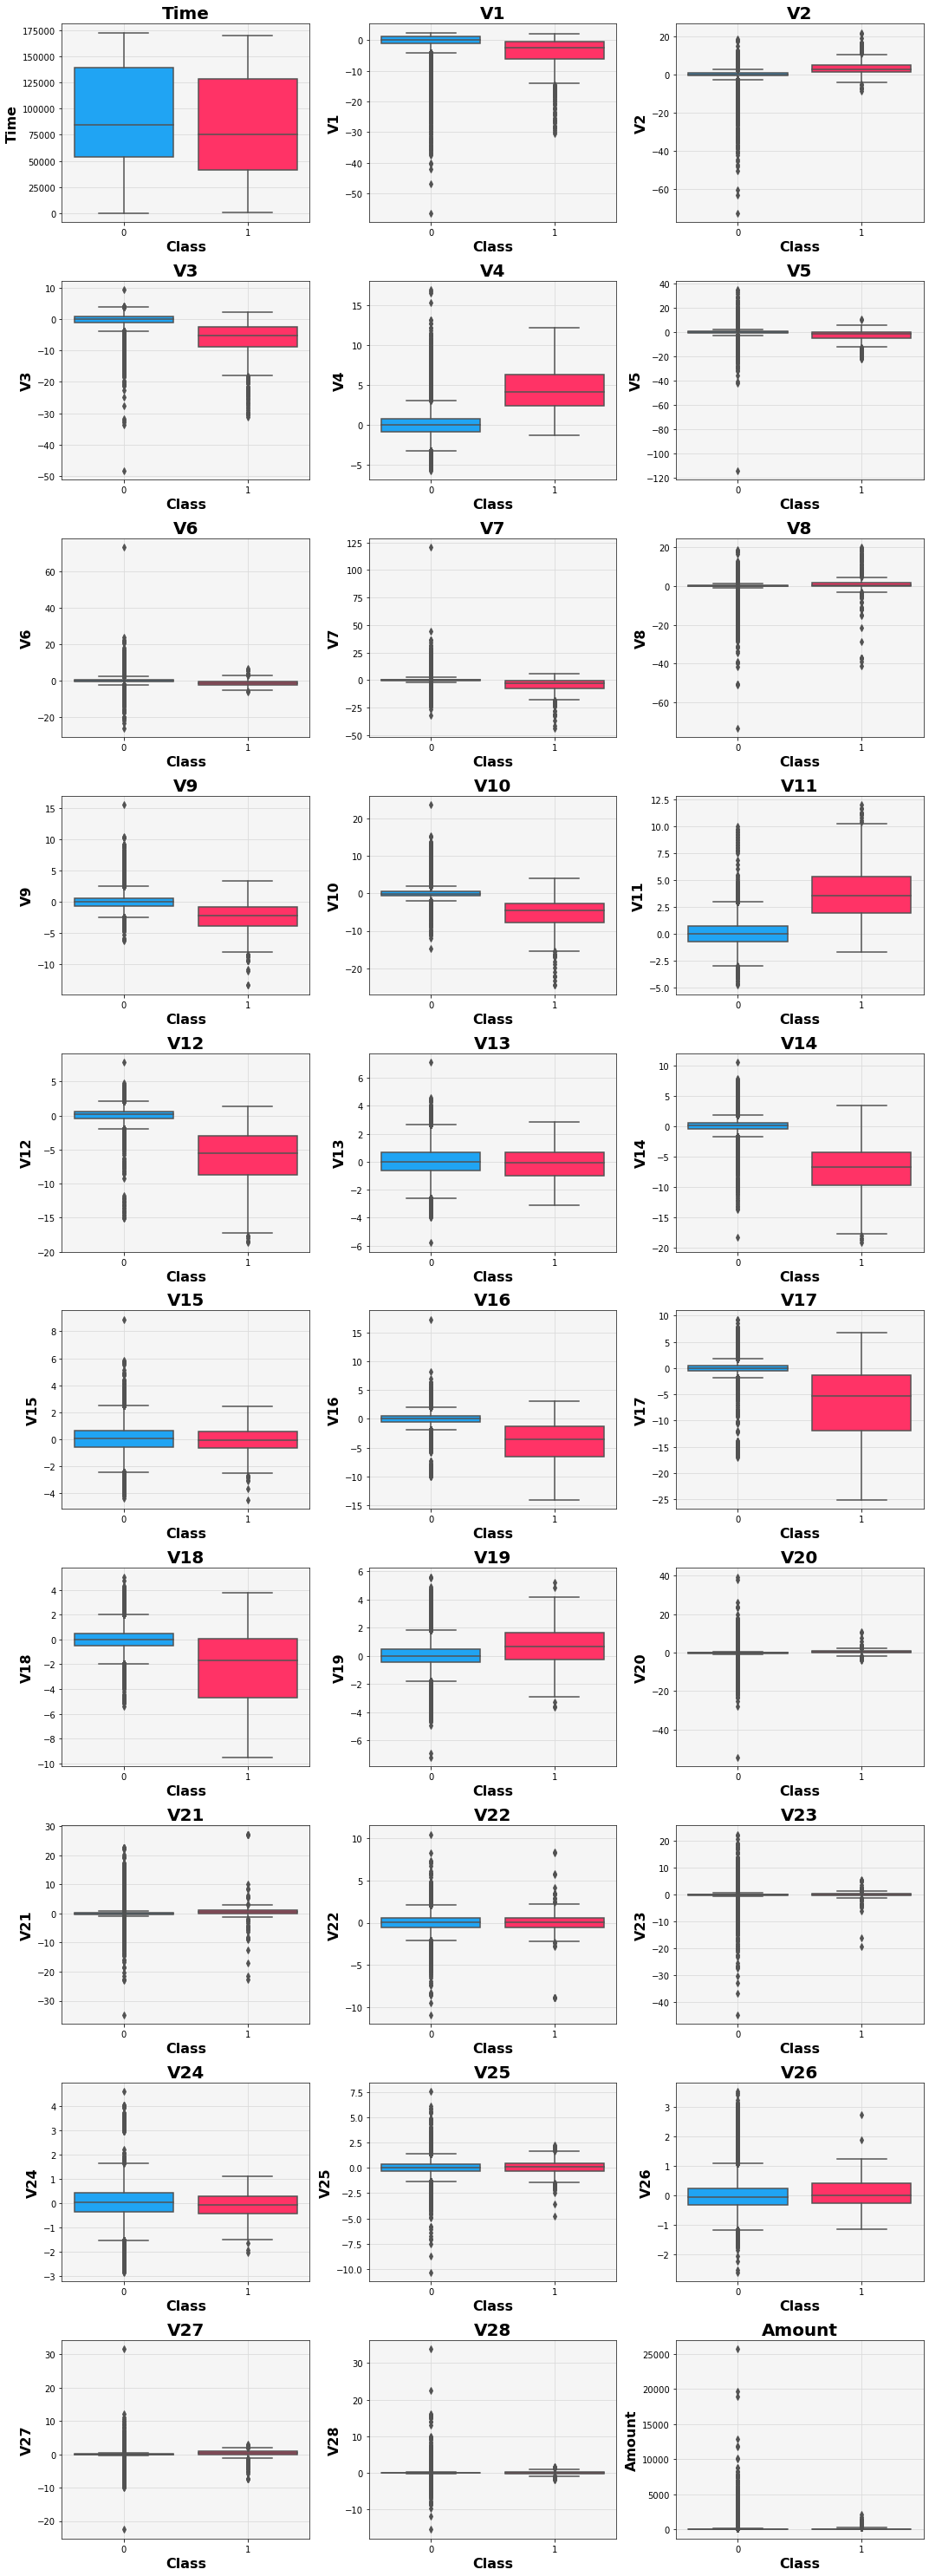

In [15]:
# columns capable of outliers
outlier_columns = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 
                    'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 
                    'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 
                    'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 
                    'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# outlier box and whisker graph
plt.figure(figsize=(15, 45))
color_palette = {0: blue_data, 1: pink_data}
for i, column in enumerate(outlier_columns, 1):
    ax = plt.subplot(11, 3, i)
    plot_boxplot(data_pandas, "Class", column, column, ax, color_palette)

**Observations:** 
* Possible majority outliers in V5-7 and minority outliers in V25-26.

* PCA transformation in these features prevents applying domain knowledge.

* The assumption that the PCA transformation results in centered data holds true.

* Logically, there will be extreme values in the Amount columns.

**Actions:** 
* Retain outliers rather than blind removal leading to lost information.

# 4.0 Data Splitting

### | 4.1 Visualise Imbalance

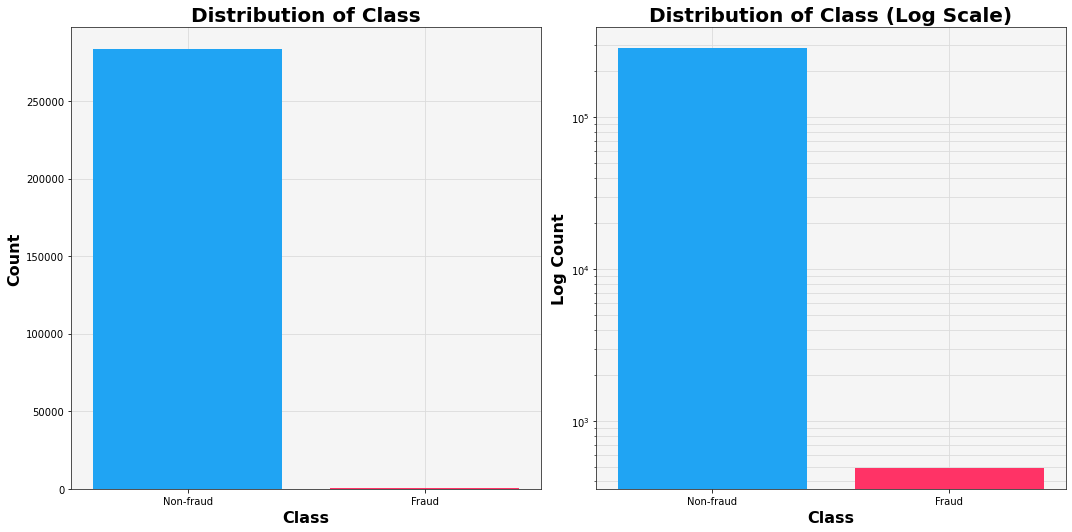

In [16]:
# extract class values and count
class_counts = data_pandas["Class"].value_counts()

# graph plots
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))

# visualise class distribution
plot_bar(
    class_counts,
    ["Non-fraud", "Fraud"],
    "Distribution of Class",
    "Class",
    "Count",
    ax[0],
    [blue_data, pink_data],
)

# visualise class distribution with log scale
plot_bar(
    class_counts,
    ["Non-fraud", "Fraud"],
    "Distribution of Class (Log Scale)",
    "Class",
    "Log Count",
    ax[1],
    [blue_data, pink_data],
    log_scale=True,
)

**Observations:** 

* Class imbalance may result in not enough minority instances in training data by chance.


**Actions:** 

* Apply stratified sampling to the dataset to ensure a representative split.

* Use a 70/30 split to ensure enough minority instances are present in the test data.

### | 4.2 Stratified Split

In [17]:
# separate target variable from dataset
X = data_pandas.drop("Class", axis=1)
y = data_pandas["Class"]

# reproducible stratified 70/30 data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_seed, stratify=y
)

# verify training distribution
print("\ny_train Class Distribution:")
print(y_train.value_counts())

# verify test distribution
print("\ny_test Class Distribution:")
print(y_test.value_counts())

# verify percentage distribution
zero_percentage = (
    y_train.value_counts().loc[0]
    / (y_train.value_counts().loc[0] + y_test.value_counts().loc[0])
    * 100
)

one_percentage = (
    y_test.value_counts().loc[1]
    / (y_train.value_counts().loc[1] + y_test.value_counts().loc[1])
    * 100
)

print("\nPercentage Distribution:")
print("0    {:.2f}%, {:.2f}%".format(zero_percentage, 100 - zero_percentage))
print("1    {:.2f}%, {:.2f}%".format(one_percentage, 100 - one_percentage))


y_train Class Distribution:
Class
0    198277
1       344
Name: count, dtype: int64

y_test Class Distribution:
Class
0    84976
1      148
Name: count, dtype: int64

Percentage Distribution:
0    70.00%, 30.00%
1    30.08%, 69.92%


**Observations:** 

* The stratified split has preserved class representation in both the training and test data.

# 5.0 Standardisation

### | 5.1 Visualise Distributions

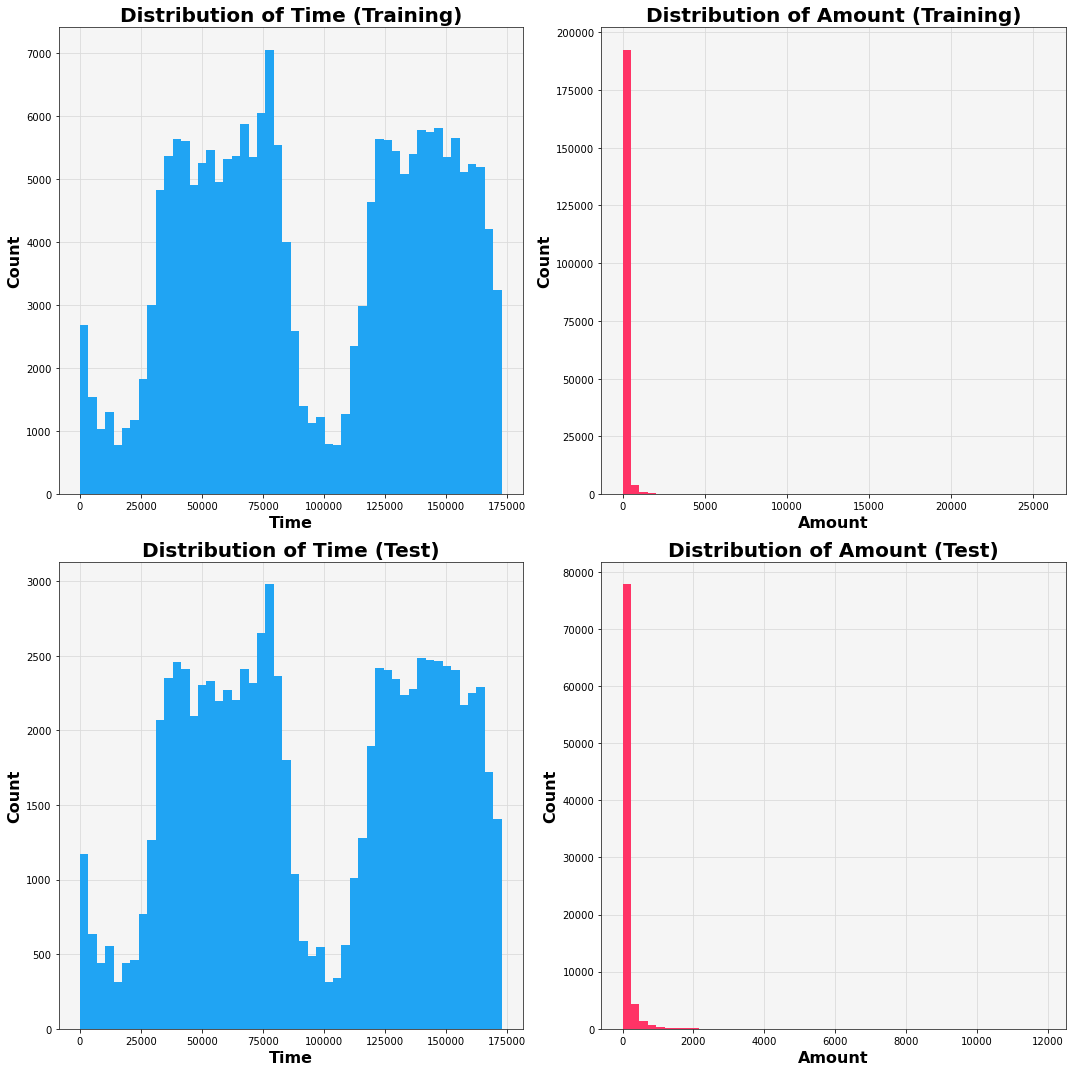

In [18]:
# graph plots
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# visualise training time and amount
plot_histogram(
    X_train["Time"],
    "Distribution of Time (Training)",
    "Time",
    "Count",
    ax[0, 0],
    blue_data,
)
plot_histogram(
    X_train["Amount"],
    "Distribution of Amount (Training)",
    "Amount",
    "Count",
    ax[0, 1],
    pink_data,
)

# visualise test time and amount
plot_histogram(
    X_test["Time"], "Distribution of Time (Test)", "Time", "Count", ax[1, 0], blue_data
)
plot_histogram(
    X_test["Amount"],
    "Distribution of Amount (Test)",
    "Amount",
    "Count",
    ax[1, 1],
    pink_data,
)


**Observations:** 
* Multiple Time peaks may relate to specific busy times of the day.

* Deriving features from Time is unlikely to be meaningful without knowing when 0 is.

* Time values need standardising as they are excessive compared to other dataset values. 

* Amount is right skewed to a heavy degree and requires intervention.

**Actions:** 
* Standardise training data and apply those scales to test data to avoid data leakage.

* Apply a logarithmic transformation with a small constant to Amount before standardising.

In [19]:
# create scalers
scaler_time = StandardScaler()
scaler_amount = StandardScaler()

# amount log transform with log(0) precaution
X_train["Amount_log"] = np.log(X_train["Amount"] + 0.01)
X_test["Amount_log"] = np.log(X_test["Amount"] + 0.01)

# fit and transform training data
X_train["Time_standardised"] = scaler_time.fit_transform(X_train[["Time"]])
X_train["Amount_standardised"] = scaler_amount.fit_transform(X_train[["Amount_log"]])

# transform test data with training scaler
X_test["Time_standardised"] = scaler_time.transform(X_test[["Time"]])
X_test["Amount_standardised"] = scaler_amount.transform(X_test[["Amount_log"]])

# remove original and helper columns
X_train = X_train.drop(columns=["Time", "Amount", "Amount_log"])
X_test = X_test.drop(columns=["Time", "Amount", "Amount_log"])

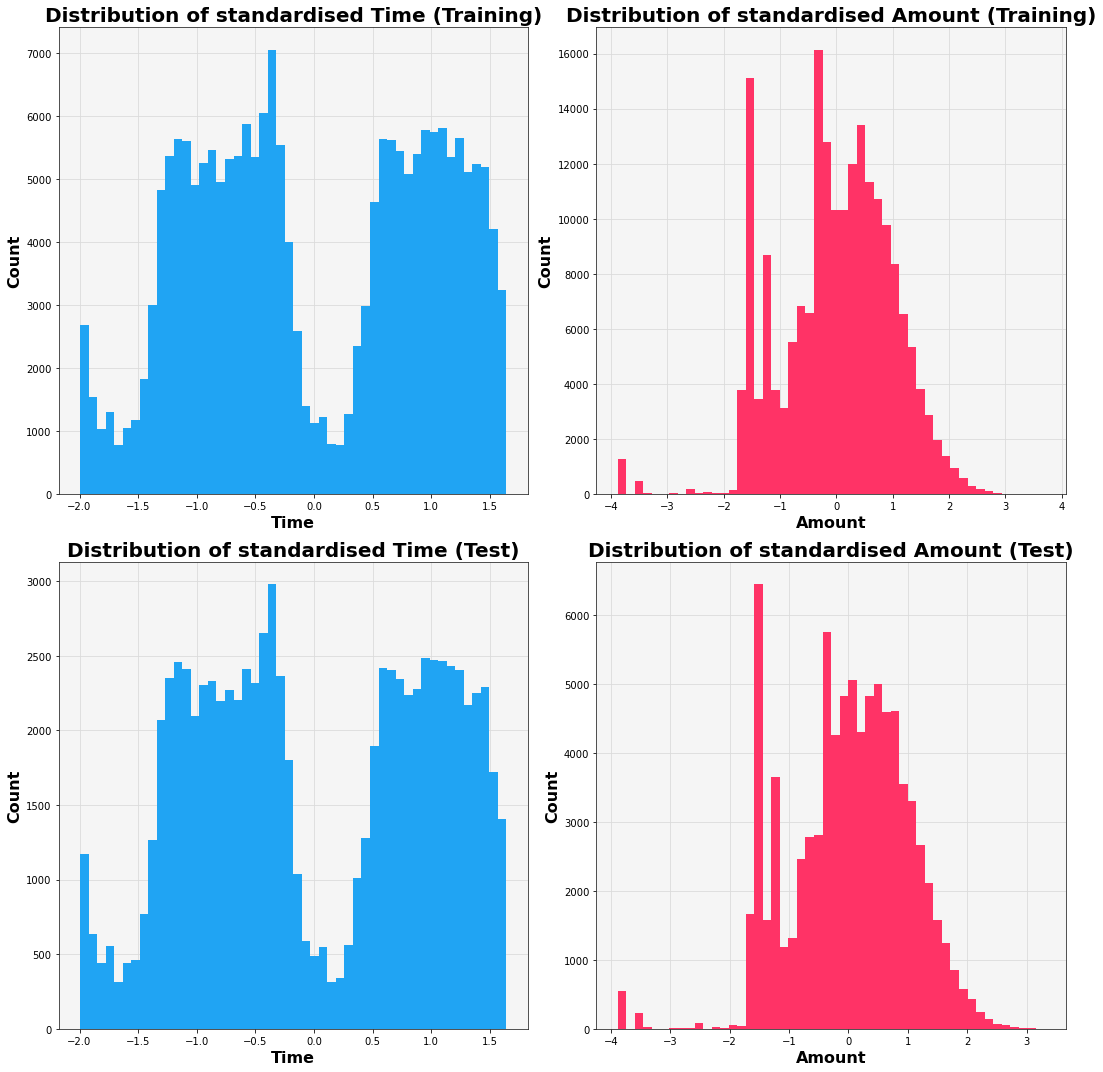

In [20]:
# graph plots
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# visualise standardised training time and amount
plot_histogram(
    X_train["Time_standardised"],
    "Distribution of standardised Time (Training)",
    "Time",
    "Count",
    ax[0, 0],
    blue_data,
)
plot_histogram(
    X_train["Amount_standardised"],
    "Distribution of standardised Amount (Training)",
    "Amount",
    "Count",
    ax[0, 1],
    pink_data,
)

# visualise standardised test time and amount
plot_histogram(
    X_test["Time_standardised"],
    "Distribution of standardised Time (Test)",
    "Time",
    "Count",
    ax[1, 0],
    blue_data,
)
plot_histogram(
    X_test["Amount_standardised"],
    "Distribution of standardised Amount (Test)",
    "Amount",
    "Count",
    ax[1, 1],
    pink_data,
)

**Observations:** 

* The mean for Amount being 0 is beneficial for certain machine learning algorithms.

* Time centered around 0 and within a few standard deviations is similarly beneficial.

* Data is now more suitable for a broader range of machine learning algorithms.

# 6.0 Exports

### | 6.1 Visualise Data

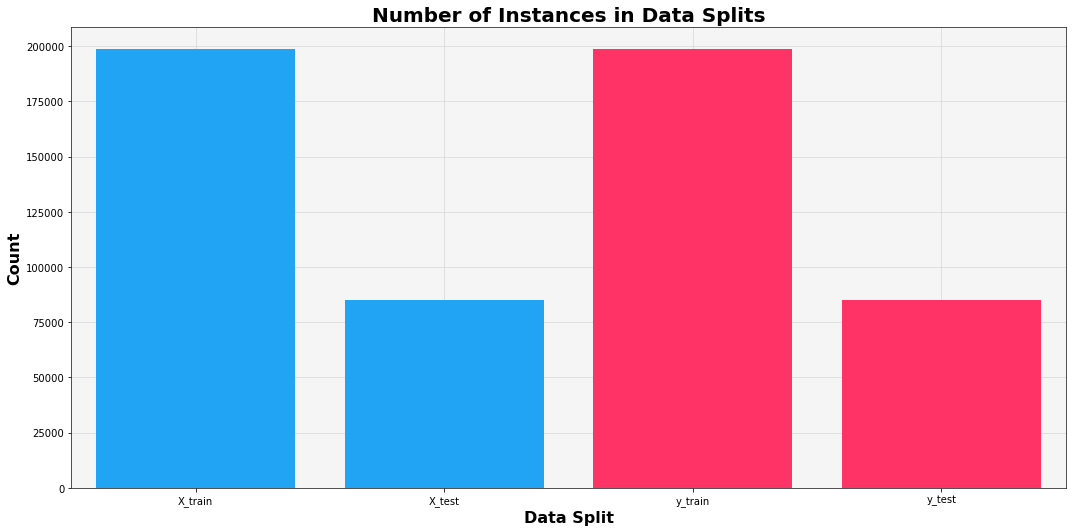

In [21]:
# graph plots
plt.figure(figsize=(15, 7.5))

# set list for visualisation
sets = ["X_train", "X_test", "y_train", "y_test"]

# colours for visualisation
counts = [X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]]
colors = [blue_data, blue_data, pink_data, pink_data]

# visualise train test instance distribution
plot_splitbar(
    sets, counts, "Number of Instances in Data Splits", "Data Split", "Count", colors
)

**Observations:** 
* X_train and y_train are processed and ready for cGAN training and benchmarking.

* X_test and y_test are processed and reserved for validation.

### | 6.2 Action Summary

* Converted float64 to float32 for performance improvements.
* Converted the values to binary integers to match algorithm expectations.
* Removed exact duplicate majority class instances.
* Retained minority duplicates to preserve information on the very low number of instances.
* Retained outliers rather than blind removal leading to lost information.
* Applied stratified sampling to the dataset to ensure a representative split.
* Used a 70/30 split to ensure enough minority instances are present in the test data.
* Standardised training data and apply those scales to test data to avoid data leakage.
* Applied a logarithmic transformation with a small constant to Amount before standardising.

### | 6.3 Export Data

In [22]:
# dataframes to export
X_train.to_pickle("./data/X_train.pkl")
X_test.to_pickle("./data/X_test.pkl")
y_train.to_pickle("./data/y_train.pkl")
y_test.to_pickle("./data/y_test.pkl")